Here I use the human against computer data to predcit the point score of rounds. The plan is to use that then for 
a new prediction. 

In [21]:
import numpy as np
import random as random
import scipy
#using simpleguitk for display, is not needed for computer game
import simpleguitk as simplegui
import time
#new ones
import pandas as pd
#ml methods
from xgboost import XGBRegressor
from xgboost import XGBClassifier
#logistic regression
from sklearn.linear_model import LogisticRegression
import os
#skyjo game classes and functions
from skyjo_functions4 import *
#own functions for machine learning
from ml_functions2 import *
#for plotting 
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

#for confidence intervalls
from scipy.stats import beta
#for splitting
from sklearn.model_selection import train_test_split
#confusing matrix
from sklearn.metrics import confusion_matrix

Loading the data in 3 lists. 

In [22]:
myPath='/home/tobias/ml-testing/games/skyjo'
list_input_files=[f for f in os.listdir(myPath) 
    if (f.startswith('human_computer1_0') or f.startswith('human_computer1_1')) and os.path.isfile(os.path.join(myPath, f))]
list_input_files.sort()
print(len(list_input_files))
#second computer implementation
list_input_files2=[f for f in os.listdir(myPath) 
    if f.startswith('human_computer3_0') and os.path.isfile(os.path.join(myPath, f))]
list_input_files2.sort()
print(len(list_input_files2))
#full games 
list_input_files3=[f for f in os.listdir(myPath) 
    if (f.startswith('human_computer1_g') or f.startswith('human_computer3_g') or  f.startswith('human_computer5_g') or  f.startswith('human_computer7_g') or  f.startswith('human_computer9_g') or  f.startswith('human_computer11_g')or  f.startswith('human_computer13_g') or  f.startswith('human_computer15_g')) and os.path.isfile(os.path.join(myPath, f))]
list_input_files3.sort()
print(len(list_input_files3))

112
24
268


First I remove from the fisrt files the double entry data.

In [23]:
listf=[]
counter=0
for i in range(len(list_input_files)):
    file=np.loadtxt(list_input_files[i])   
    #get previous also to check that it is doe snot include also old input
    if i>0:
        ofile=np.loadtxt(list_input_files[i-1])  
        #append all if equal besides score or beyound game 50
        if sum(np.round(ofile[0:49,0]))!=sum(np.round(file[0:49,0])) or i>50:
            #add round number here 
            finfile=np.zeros((file.shape[0]+1,file.shape[1]))
            finfile[:file.shape[0],:file.shape[1]]=file
            finfile[file.shape[0],:file.shape[1]]=i
            listf.append(finfile)
        else:
            #otherwise only append the difference
            finfile=np.zeros((file.shape[0]+1,file.shape[1]-ofile.shape[1]))
            finfile[:file.shape[0],:file.shape[1]]=file[:,ofile.shape[1]:file.shape[1]]
            finfile[file.shape[0],:file.shape[1]]=i
            #chnage round number in it
            finfile[48]=range(finfile.shape[1])
            listf.append(finfile)
            #could add rounds from end, but better not since not possible in reality
    else:
        finfile=np.zeros((file.shape[0]+1,file.shape[1]))
        finfile[:file.shape[0],:file.shape[1]]=file
        finfile[file.shape[0],:file.shape[1]]=i
        listf.append(finfile)
    counter+=1
#then adding the next one     

In [24]:
#then adding the next one list which does not has such a problem and the same inout shape 
for i in range(len(list_input_files2)):
    file=np.loadtxt(list_input_files2[i])   
    finfile=np.zeros((file.shape[0]+1,file.shape[1]))
    finfile[:file.shape[0],:file.shape[1]]=file
    finfile[file.shape[0],:file.shape[1]]=counter
    listf.append(finfile)
    counter+=1

In [25]:
#now adding the others which are full games, but here they are dissected into rounds 
for i in range(len(list_input_files3)):
    file=np.loadtxt(list_input_files3[i])   
    finfile=np.zeros((52,file.shape[1]))
    #finfile[:file.shape[0],:file.shape[1]]=file
    for j in range(file.shape[1]):
        finfile[0:51,j]=file[0:51,j]
        finfile[51,j]=int(counter+file[51,j])             
    listf.append(finfile)
    counter+=int(max(file[51,:])+1)
print(f"number of rounds included is {counter}")    

number of rounds included is 998


In [26]:
random.shuffle(listf)
ar=lists_arrays_to_one(listf)
print(ar.shape)

(52, 28433)


In [ ]:
Now making it to a data frame. 

In [28]:
columns=['acting_player']
columns.append('open_pile_card')
for i in range(15):
    columns.append('number_of_'+str(i-2)+'_in_open')
columns.append('number_of_cards_in_closed')
for i in range(12):
    columns.append('own_cards_'+str(i))
for i in range(12):
    columns.append('other_player_cards_'+str(i))    
columns.append('action_take_open')
columns.append('action_discard')
columns.append('discard_value')
columns.append('id_player_card')
columns.append('numeric_player_card') 
columns.append('vanish_marker')
columns.append('turn')
columns.append('score_self')
columns.append('score_other')
columns.append('round_number')
print(len(columns),columns)
for i in range(43,52):
    print(i)
    print(columns[i],ar[i]) 
df = pd.DataFrame(data = ar.T, index=range(ar.shape[1]),columns = columns)
#adding some summarizing columns
df['own_n_closed']=df.loc[:,'own_cards_0':'own_cards_11'][df.loc[:,'own_cards_0':'own_cards_11']==20].count(axis=1)
#now n_open isstead because small n_vanished likely cases pron=blem in deep learning
df['own_n_open']=df.loc[:,'own_cards_0':'own_cards_11'][(df.loc[:,'own_cards_0':'own_cards_11']!=30) & (df.loc[:,'own_cards_0':'own_cards_11']!=20)].count(axis=1)
df['own_max']=df.loc[:,'own_cards_0':'own_cards_11'][(df.loc[:,'own_cards_0':'own_cards_11']!=20) & (df.loc[:,'own_cards_0':'own_cards_11']!=30)].max(axis=1)
df['own_sum']=df.loc[:,'own_cards_0':'own_cards_11'][(df.loc[:,'own_cards_0':'own_cards_11']!=20) & (df.loc[:,'own_cards_0':'own_cards_11']!=30)].sum(axis=1)
df['other_player_n_closed']=df.loc[:,'other_player_cards_0':'other_player_cards_11'][df.loc[:,'other_player_cards_0':'other_player_cards_11']==20].count(axis=1)
df['other_player_n_open']=df.loc[:,'other_player_cards_0':'other_player_cards_11'][(df.loc[:,'other_player_cards_0':'other_player_cards_11']!=20) & (df.loc[:,'other_player_cards_0':'other_player_cards_11']!=30)].count(axis=1)
df['other_player_max']=df.loc[:,'other_player_cards_0':'other_player_cards_11'][(df.loc[:,'other_player_cards_0':'other_player_cards_11']!=20) & (df.loc[:,'other_player_cards_0':'other_player_cards_11']!=30)].max(axis=1)
df['other_player_sum']=df.loc[:,'other_player_cards_0':'other_player_cards_11'][(df.loc[:,'other_player_cards_0':'other_player_cards_11']!=20) & (df.loc[:,'other_player_cards_0':'other_player_cards_11']!=30)].sum(axis=1)

print(df.head())


52 ['acting_player', 'open_pile_card', 'number_of_-2_in_open', 'number_of_-1_in_open', 'number_of_0_in_open', 'number_of_1_in_open', 'number_of_2_in_open', 'number_of_3_in_open', 'number_of_4_in_open', 'number_of_5_in_open', 'number_of_6_in_open', 'number_of_7_in_open', 'number_of_8_in_open', 'number_of_9_in_open', 'number_of_10_in_open', 'number_of_11_in_open', 'number_of_12_in_open', 'number_of_cards_in_closed', 'own_cards_0', 'own_cards_1', 'own_cards_2', 'own_cards_3', 'own_cards_4', 'own_cards_5', 'own_cards_6', 'own_cards_7', 'own_cards_8', 'own_cards_9', 'own_cards_10', 'own_cards_11', 'other_player_cards_0', 'other_player_cards_1', 'other_player_cards_2', 'other_player_cards_3', 'other_player_cards_4', 'other_player_cards_5', 'other_player_cards_6', 'other_player_cards_7', 'other_player_cards_8', 'other_player_cards_9', 'other_player_cards_10', 'other_player_cards_11', 'action_take_open', 'action_discard', 'discard_value', 'id_player_card', 'numeric_player_card', 'vanish_marker

Select some columns since it is not enough data to train on all. Are the same columns as in model5 to make it easier. 

In [29]:
newcolumns=['open_pile_card', 'own_n_closed', 'own_max',
       'own_sum', 'other_player_n_closed',
       'other_player_max', 'other_player_sum', 'action_take_open', 'action_discard',
       'discard_value','numeric_player_card', 'score_self',
       'score_other', 'round_number']
df2=df.loc[:,newcolumns]

Splitting the data by round number in test and train to have no correlation between test and train. 

In [32]:
print(df2.shape)

feature_train,feature_test, target_train,target_test=split_test(df2.iloc[:,0:11],df2.score_self-df2.score_other, df2.iloc[:,13],0.6)

(28433, 14)
17060
17075


Start with standard xgboost. 

In [33]:
ar=do_xgb(feature_train, target_train, feature_test, target_test,6,reg=0)
print(ar)

xgb took 0.4189 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 28.4524 points
standard deviation of prediction-train 18.0592 points
[ 0.          6.         18.0592296  28.45237092]


There is a lot of overfitting, exploring the usual grid of regularization and depth. 

In [36]:
for i in range(1,9):
    loop_reg(feature_train, target_train, feature_test, target_test,i,1,1.414,25,"xgb_human_scores_maxd0"+str(i)+".txt")

doing case 0
xgb took 0.1007 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 28.407 points
standard deviation of prediction-train 25.6382 points
doing case 1
xgb took 0.0736 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 28.4071 points
standard deviation of prediction-train 25.6382 points
doing case 2
xgb took 0.0995 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 28.4072 points
standard deviation of prediction-train 25.6383 points
doing case 3
xgb took 0.075 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 28.4074 points
standard deviation of prediction-train 25.6384 points
doing case 4
xgb took 0.0706 seconds
standard deviation of test 32.1907 points
sta

xgb took 0.1572 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 27.7574 points
standard deviation of prediction-train 24.3749 points
doing case 12
xgb took 0.1397 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 27.7415 points
standard deviation of prediction-train 24.3802 points
doing case 13
xgb took 0.155 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 27.6999 points
standard deviation of prediction-train 24.4069 points
doing case 14
xgb took 0.1391 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 27.7292 points
standard deviation of prediction-train 24.4244 points
doing case 15
xgb took 0.1241 seconds
standard deviation of test 32.1907 points
standard de

xgb took 0.1964 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 28.3338 points
standard deviation of prediction-train 24.8263 points
doing case 24
xgb took 0.1642 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 28.5997 points
standard deviation of prediction-train 25.1443 points
doing case 0
xgb took 0.277 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 27.8204 points
standard deviation of prediction-train 22.0038 points
doing case 1
xgb took 0.2447 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 27.8418 points
standard deviation of prediction-train 22.0103 points
doing case 2
xgb took 0.2333 seconds
standard deviation of test 32.1907 points
standard devia

xgb took 0.2647 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 27.9395 points
standard deviation of prediction-train 20.3789 points
doing case 10
xgb took 0.2625 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 27.9082 points
standard deviation of prediction-train 20.5226 points
doing case 11
xgb took 0.2625 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 28.1318 points
standard deviation of prediction-train 20.3711 points
doing case 12
xgb took 0.2976 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 27.8432 points
standard deviation of prediction-train 20.488 points
doing case 13
xgb took 0.305 seconds
standard deviation of test 32.1907 points
standard dev

xgb took 0.2453 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 27.7603 points
standard deviation of prediction-train 23.0676 points
doing case 21
xgb took 0.2353 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 27.9682 points
standard deviation of prediction-train 23.6408 points
doing case 22
xgb took 0.2621 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 28.0822 points
standard deviation of prediction-train 24.0245 points
doing case 23
xgb took 0.2106 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 28.3125 points
standard deviation of prediction-train 24.4488 points
doing case 24
xgb took 0.1734 seconds
standard deviation of test 32.1907 points
standard d

xgb took 0.5758 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 28.8186 points
standard deviation of prediction-train 12.0312 points
doing case 7
xgb took 0.5839 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 28.7648 points
standard deviation of prediction-train 12.1302 points
doing case 8
xgb took 0.5332 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 28.8462 points
standard deviation of prediction-train 12.1444 points
doing case 9
xgb took 0.6471 seconds
standard deviation of test 32.1907 points
standard deviation of train 29.6703  points
standard deviation of prediction-test 28.6726 points
standard deviation of prediction-train 12.3276 points
doing case 10
xgb took 0.589 seconds
standard deviation of test 32.1907 points
standard devia

In [ ]:
Then I look at the minima. 

In [39]:
hum1=np.loadtxt("xgb_human_scores_maxd01.txt")
hum2=np.loadtxt("xgb_human_scores_maxd02.txt")
hum3=np.loadtxt("xgb_human_scores_maxd03.txt")
hum4=np.loadtxt("xgb_human_scores_maxd04.txt")
hum5=np.loadtxt("xgb_human_scores_maxd05.txt")
hum6=np.loadtxt("xgb_human_scores_maxd06.txt")
hum7=np.loadtxt("xgb_human_scores_maxd07.txt")
hum8=np.loadtxt("xgb_human_scores_maxd08.txt")
print(f"minimum standard deviation of (prediction-test data) {round(min(hum1[3]),4)} of max-depth=1")
print(f"minimum standard deviation of (prediction-test data) {round(min(hum2[3]),4)} of max-depth=2")
print(f"minimum standard deviation of (prediction-test data) {round(min(hum3[3]),4)} of max-depth=3")
print(f"minimum standard deviation of (prediction-test data) {round(min(hum4[3]),4)} of max-depth=4")
print(f"minimum standard deviation of (prediction-test data) {round(min(hum5[3]),4)} of max-depth=5")
print(f"minimum standard deviation of (prediction-test data) {round(min(hum6[3]),4)} of max-depth=6")
print(f"minimum standard deviation of (prediction-test data) {round(min(hum7[3]),4)} of max-depth=7")
print(f"minimum standard deviation of (prediction-test data) {round(min(hum8[3]),4)} of max-depth=8")

minimum standard deviation of (prediction-test data) 28.3776 of max-depth=1
minimum standard deviation of (prediction-test data) 27.6691 of max-depth=2
minimum standard deviation of (prediction-test data) 27.5402 of max-depth=3
minimum standard deviation of (prediction-test data) 27.5331 of max-depth=4
minimum standard deviation of (prediction-test data) 27.6093 of max-depth=5
minimum standard deviation of (prediction-test data) 27.6459 of max-depth=6
minimum standard deviation of (prediction-test data) 27.7333 of max-depth=7
minimum standard deviation of (prediction-test data) 27.7218 of max-depth=8


Looks like the minimum is at at a depth of 4, I now plots the best against regularziation to see whether the minimum is within the alpha range and not outside of the explored range. 

The regularization of the best standard deviation is 255.38215735555565


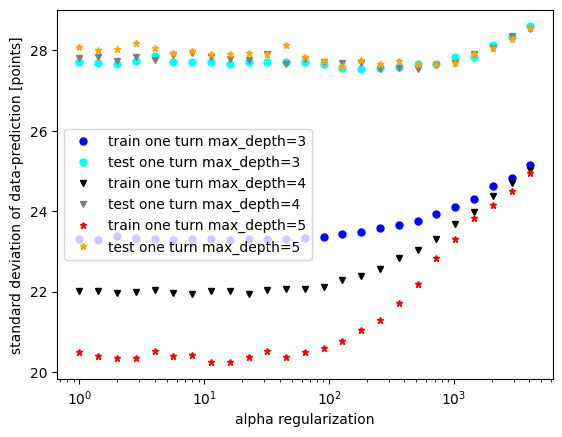

In [41]:
plt.plot(hum3[0],hum3[2],'o',ms=5,color='blue',label='train one turn max_depth=3') 
plt.plot(hum3[0],hum3[3],'o',ms=5,color='cyan',label='test one turn max_depth=3')
plt.plot(hum4[0],hum4[2],'v',ms=5,color='black',label='train one turn max_depth=4') 
plt.plot(hum4[0],hum4[3],'v',ms=5,color='gray',label='test one turn max_depth=4')
plt.plot(hum5[0],hum5[2],'*',ms=5,color='red',label='train one turn max_depth=5') 
plt.plot(hum5[0],hum5[3],'*',ms=5,color='orange',label='test one turn max_depth=5')
plt.legend(loc="best")
plt.xscale("log")
#plt.ylim(55,65)
plt.xlabel("alpha regularization")
plt.ylabel("standard deviation of data-prediction [points]")
print(f"The regularization of the best standard deviation is {hum4[0,np.argmin(hum4[3])]}") 

It is well covered. Thus it used to make model 17. It is fitted on the data that it can use it. 

The difference between test and train is clearly larger than when the same feature were trained on the random data set. That data set had also the difference that there was only one turn per round used for training, thus there was no correlation test and train automatically, thus the comparsion is not fair.  

In [42]:

regxl29=XGBRegressor(max_depth=4,reg_alpha=255.38215735555565).fit(df2.iloc[:,0:11],df2.score_self-df2.score_other)
#and save it
regxl29.save_model("xgb_model17.json")



Text(0, 0.5, 'feature importance')

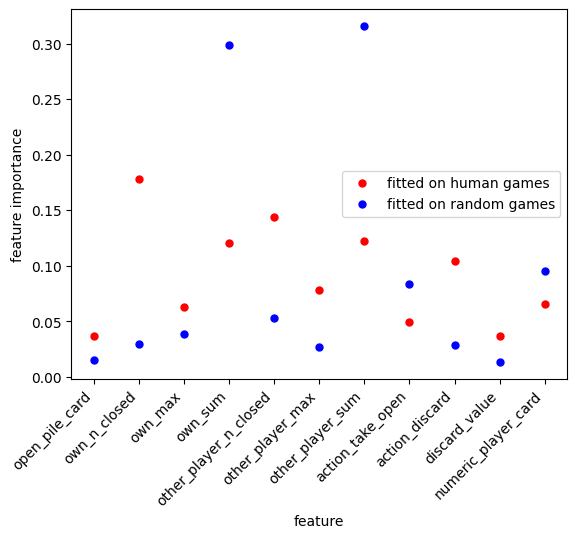

In [45]:
regxl30=XGBRegressor()
regxl30.load_model("xgb_model1eb.json")
plt.plot(feature_train.columns,regxl29.feature_importances_,'o',ms=5,color='red',label='fitted on human games') 
plt.plot(feature_train.columns,regxl30.feature_importances_,'o',ms=5,color='blue',label='fitted on random games') 
plt.legend(loc="best")
#plt.xscale("log")
#plt.ylim(55,65)
plt.xticks(rotation=45, ha='right')
plt.xlabel("feature")
plt.ylabel("feature importance")

There is a range of importance of them, not so clear whether it is a good one, seems arbitrary, still it is implemented now. 